# Welcome to 24-789 Homework 3

In this homework you will implement a [Denoising Diffusion Probabilistic Model](https://arxiv.org/pdf/2006.11239.pdf). Please start early as diffusion models are notoriously slow to train. Please remember to restart and run all before submission.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks"

24789_HW3.zip  HW4_24788_Spring_24_Final.ipynb	MNIST_Diffusion.ipynb  unet.py


In [ ]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/24789_HW3.zip"

In [ ]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
from unet import Unet
import os
import math
import torch.optim as optim
from matplotlib import pyplot as plt
from torch.optim import lr_scheduler

torch.manual_seed(0)

In [ ]:
def create_mnist_dataloaders(batch_size,image_size=28,num_workers=2):
    '''
        Data loading code. Do not modify.
    '''

    preprocess=transforms.Compose([transforms.Resize(image_size),\
                                    transforms.ToTensor(),\
                                    transforms.Normalize([0.5],[0.5])]) #[0,1] to [-1,1]

    train_dataset=MNIST(root="./mnist_data",\
                        train=True,\
                        download=True,\
                        transform=preprocess
                        )

    # Pick out only the first 5000 1s
    valid_idxs = []
    for idx, d in enumerate(train_dataset):
        if(d[1] in [1]):
            valid_idxs.append(idx)
        if(len(valid_idxs) >= 5000):
            break

    # Create subset
    train_dataset = torch.utils.data.Subset(train_dataset, valid_idxs)

    return DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)

## a,b,c,d) Model Implementation

In this section you will implement each part of the diffusion model. That is the model parameters, forward diffusion, reverse diffusion, and the denoising sampling procedure.

In [ ]:
import torch.nn as nn
import torch
import math
from tqdm import tqdm

class MNISTDiffusion(nn.Module):
    def __init__(self,image_size,in_channels,time_embedding_dim=256,timesteps=1000,base_dim=32,dim_mults= [1, 2, 4, 8]):
        super().__init__()

        ###
        #  Part a: Your code here
        ###
        self.image_size = image_size
        self.in_channels = in_channels
        self.timesteps = timesteps
        self.device = "cuda"

        betas = self._cosine_variance_schedule(timesteps)

        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas,dim =-1)



        self.register_buffer("betas",betas)
        self.register_buffer("alphas",alphas)
        self.register_buffer("alphas_cumprod",alphas_cumprod)
        self.register_buffer("sqrt_alphas_cumprod",torch.sqrt(alphas_cumprod))
        self.register_buffer("sqrt_one_minus_alphas_cumprod",torch.sqrt(1.-alphas_cumprod))

        self.model=Unet(timesteps,time_embedding_dim,in_channels,in_channels,base_dim,dim_mults)

    def _cosine_variance_schedule(self,timesteps,epsilon= 0.008):

        steps=torch.linspace(0, timesteps, steps=timesteps+1, dtype=torch.float32)
        f_t = torch.cos(((steps/timesteps+epsilon)/(1.0+epsilon))*math.pi*0.5)**2
        betas=torch.clip(1.0-f_t[1:]/f_t[:timesteps],0.0,0.999)

        return betas


    def forward(self,x,noise):
        # x:NCHW
        # Generate a target time, run forward diffusion, and predict

        ###
        #  Part b: Your code here
        ###

        t = torch.randint(0, self.timesteps, (x.shape[0],)).to(x.device)

        x_t=self._forward_diffusion(x,t,noise)
        pred_noise=self.model(x_t,t)

        return pred_noise


    def _forward_diffusion(self,x_0,t,noise):

        ###
        #  Part b: Your code here
        ###

        assert x_0.shape==noise.shape
        noisy_sample = self.sqrt_alphas_cumprod.gather(-1,t).reshape(x_0.shape[0],1,1,1)*x_0+ \
                self.sqrt_one_minus_alphas_cumprod.gather(-1,t).reshape(x_0.shape[0],1,1,1)*noise

        return noisy_sample


    @torch.no_grad()
    def _reverse_diffusion(self,x_t,t,noise):
        '''
        p(x_{t-1}|x_{t})-> mean,std

        pred_noise-> pred_mean and pred_std
        '''

        ###
        #  Part c: Your code here
        ###

        pred=self.model(x_t,t)

        alpha_t=self.alphas.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        alpha_t_cumprod=self.alphas_cumprod.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        beta_t=self.betas.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        sqrt_one_minus_alpha_cumprod_t=self.sqrt_one_minus_alphas_cumprod.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        mean=(1./torch.sqrt(alpha_t))*(x_t-((1.0-alpha_t)/sqrt_one_minus_alpha_cumprod_t)*pred)

        if t.min()>0:
            alpha_t_cumprod_prev=self.alphas_cumprod.gather(-1,t-1).reshape(x_t.shape[0],1,1,1)
            std=torch.sqrt(beta_t*(1.-alpha_t_cumprod_prev)/(1.-alpha_t_cumprod))
        else:
            std=0.0
        return mean+std*noise


    @torch.no_grad()
    def sampling(self,n_samples,device="cuda"):

        ###
        #  Part d: Your code here
        ###

        all_samples = []
        sample = torch.randn((n_samples, self.in_channels, self.image_size, self.image_size)).to(device)
        for i in tqdm(range(self.timesteps - 1, -1, -1), desc="Sampling"):
            noise = torch.randn_like(sample).to(device)
            t = torch.tensor([i for _ in range(n_samples)]).to(device)
            sample = self._reverse_diffusion(sample, t, noise)

        sample = (sample+1.)/2
        all_samples.append(sample)

        return sample.clone(), torch.stack(all_samples).clone()

## e) Model Training

Now it is time to implement your training loop. You will need to choose a learning rate, batch size, number of epochs, model dimension, and number of timesteps. You will also need to select an optimizer, scheduler, and loss function.

In [ ]:
def main():
    device = "cuda" if torch.cuda.is_available() else 'cpu'

    # Model and training hyperparameters
    lr = 0.005
    batch_size = 64
    epochs = 50
    model_base_dim = 32

    # Number of noising/denoising steps to take
    timesteps = 10000

    # Controls how often loss is printed and plots are generated
    log_freq = 10
    plot_freq = 10

    # For plotting. Do not modify.
    n_samples = 36

    # Get data
    train_dataloader=create_mnist_dataloaders(batch_size=batch_size,image_size=28)

    # Get model
    model=MNISTDiffusion(timesteps=timesteps,
                image_size=28,
                in_channels=1,
                base_dim=model_base_dim,
                dim_mults=[2,4]).to(device)


    optimizer = optim.Adam(model.parameters(),lr=lr)
    scheduler = OneCycleLR(optimizer,lr,total_steps=epochs*len(train_dataloader),pct_start=0.25,anneal_strategy='cos')
    loss_fn = nn.MSELoss(reduction = 'mean')

    global_steps=0
    for i in range(epochs):
        model.train()
        for j,(image,target) in enumerate(train_dataloader):

            # Implement your forward pass and backpropagation

            noise=torch.randn_like(image).to(device)
            image=image.to(device)
            pred=model(image,noise)
            loss=loss_fn(pred,noise)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            scheduler.step()


            # Print training progress
            global_steps+=1
            if j%log_freq==0:
                print("Epoch[{}/{}],Step[{}/{}],loss:{:.5f},lr:{:.5f}".format(i+1,epochs,j,len(train_dataloader),
                                                                    loss.detach().cpu().item(),scheduler.get_last_lr()[0]))


        if(i%plot_freq == 0):
            ckpt={"model":model.state_dict()}
            os.makedirs("results",exist_ok=True)
            torch.save(ckpt,"results/steps_{:0>8}.pt".format(global_steps))
            model.eval()
            s, samples = model.sampling(n_samples,device=device)
            save_image(s,"results/steps_{:0>8}.png".format(global_steps),nrow=int(math.sqrt(n_samples)))

    # Final round of plots
    os.makedirs("results",exist_ok=True)
    torch.save(ckpt,"results/steps_{:0>8}.pt".format(global_steps))

    model.eval()
    s, samples=model.sampling(n_samples,device=device)
    save_image(s,"results/steps_{:0>8}.png".format(global_steps),nrow=int(math.sqrt(n_samples)))

    return samples

In [ ]:
samples = main()

Epoch[1/50],Step[0/79],loss:1.07099,lr:0.00020
Epoch[1/50],Step[10/79],loss:1.04397,lr:0.00020
Epoch[1/50],Step[20/79],loss:1.00819,lr:0.00021
Epoch[1/50],Step[30/79],loss:0.98490,lr:0.00021
Epoch[1/50],Step[40/79],loss:0.96618,lr:0.00022
Epoch[1/50],Step[50/79],loss:0.92172,lr:0.00023
Epoch[1/50],Step[60/79],loss:0.90354,lr:0.00025
Epoch[1/50],Step[70/79],loss:0.86714,lr:0.00026


Sampling: 100%|██████████| 10000/10000 [03:32<00:00, 46.98it/s]


Epoch[2/50],Step[0/79],loss:0.83676,lr:0.00028
Epoch[2/50],Step[10/79],loss:0.78667,lr:0.00030
Epoch[2/50],Step[20/79],loss:0.74388,lr:0.00032
Epoch[2/50],Step[30/79],loss:0.71041,lr:0.00035
Epoch[2/50],Step[40/79],loss:0.65258,lr:0.00037
Epoch[2/50],Step[50/79],loss:0.59639,lr:0.00040
Epoch[2/50],Step[60/79],loss:0.54680,lr:0.00043
Epoch[2/50],Step[70/79],loss:0.53055,lr:0.00047
Epoch[3/50],Step[0/79],loss:0.47392,lr:0.00050
Epoch[3/50],Step[10/79],loss:0.45343,lr:0.00054
Epoch[3/50],Step[20/79],loss:0.44566,lr:0.00058
Epoch[3/50],Step[30/79],loss:0.38725,lr:0.00062
Epoch[3/50],Step[40/79],loss:0.36610,lr:0.00067
Epoch[3/50],Step[50/79],loss:0.33830,lr:0.00071
Epoch[3/50],Step[60/79],loss:0.33288,lr:0.00076
Epoch[3/50],Step[70/79],loss:0.33642,lr:0.00081
Epoch[4/50],Step[0/79],loss:0.29155,lr:0.00086
Epoch[4/50],Step[10/79],loss:0.27412,lr:0.00091
Epoch[4/50],Step[20/79],loss:0.30395,lr:0.00097
Epoch[4/50],Step[30/79],loss:0.23571,lr:0.00102
Epoch[4/50],Step[40/79],loss:0.23180,lr:0.0

Sampling: 100%|██████████| 10000/10000 [03:35<00:00, 46.48it/s]


Epoch[12/50],Step[0/79],loss:0.05353,lr:0.00484
Epoch[12/50],Step[10/79],loss:0.05668,lr:0.00486
Epoch[12/50],Step[20/79],loss:0.04903,lr:0.00489
Epoch[12/50],Step[30/79],loss:0.06399,lr:0.00491
Epoch[12/50],Step[40/79],loss:0.04475,lr:0.00493
Epoch[12/50],Step[50/79],loss:0.04315,lr:0.00495
Epoch[12/50],Step[60/79],loss:0.04693,lr:0.00496
Epoch[12/50],Step[70/79],loss:0.06312,lr:0.00497
Epoch[13/50],Step[0/79],loss:0.04808,lr:0.00498
Epoch[13/50],Step[10/79],loss:0.04419,lr:0.00499
Epoch[13/50],Step[20/79],loss:0.04112,lr:0.00500
Epoch[13/50],Step[30/79],loss:0.05075,lr:0.00500
Epoch[13/50],Step[40/79],loss:0.05191,lr:0.00500
Epoch[13/50],Step[50/79],loss:0.05482,lr:0.00500
Epoch[13/50],Step[60/79],loss:0.04474,lr:0.00500
Epoch[13/50],Step[70/79],loss:0.04885,lr:0.00500
Epoch[14/50],Step[0/79],loss:0.04783,lr:0.00500
Epoch[14/50],Step[10/79],loss:0.05258,lr:0.00500
Epoch[14/50],Step[20/79],loss:0.05640,lr:0.00499
Epoch[14/50],Step[30/79],loss:0.03990,lr:0.00499
Epoch[14/50],Step[40/79

Sampling: 100%|██████████| 10000/10000 [03:29<00:00, 47.82it/s]


Epoch[22/50],Step[0/79],loss:0.03798,lr:0.00439
Epoch[22/50],Step[10/79],loss:0.02848,lr:0.00437
Epoch[22/50],Step[20/79],loss:0.03298,lr:0.00435
Epoch[22/50],Step[30/79],loss:0.03952,lr:0.00434
Epoch[22/50],Step[40/79],loss:0.02808,lr:0.00432
Epoch[22/50],Step[50/79],loss:0.03519,lr:0.00430
Epoch[22/50],Step[60/79],loss:0.03524,lr:0.00428
Epoch[22/50],Step[70/79],loss:0.03580,lr:0.00426
Epoch[23/50],Step[0/79],loss:0.05440,lr:0.00425
Epoch[23/50],Step[10/79],loss:0.03090,lr:0.00423
Epoch[23/50],Step[20/79],loss:0.02880,lr:0.00421
Epoch[23/50],Step[30/79],loss:0.03353,lr:0.00419
Epoch[23/50],Step[40/79],loss:0.03056,lr:0.00417
Epoch[23/50],Step[50/79],loss:0.03587,lr:0.00415
Epoch[23/50],Step[60/79],loss:0.03369,lr:0.00413
Epoch[23/50],Step[70/79],loss:0.03163,lr:0.00411
Epoch[24/50],Step[0/79],loss:0.04504,lr:0.00409
Epoch[24/50],Step[10/79],loss:0.03231,lr:0.00407
Epoch[24/50],Step[20/79],loss:0.03026,lr:0.00405
Epoch[24/50],Step[30/79],loss:0.03361,lr:0.00403
Epoch[24/50],Step[40/79

Sampling: 100%|██████████| 10000/10000 [03:35<00:00, 46.48it/s]


Epoch[32/50],Step[0/79],loss:0.02096,lr:0.00255
Epoch[32/50],Step[10/79],loss:0.03257,lr:0.00252
Epoch[32/50],Step[20/79],loss:0.04112,lr:0.00249
Epoch[32/50],Step[30/79],loss:0.02758,lr:0.00247
Epoch[32/50],Step[40/79],loss:0.02710,lr:0.00244
Epoch[32/50],Step[50/79],loss:0.03161,lr:0.00241
Epoch[32/50],Step[60/79],loss:0.02748,lr:0.00239
Epoch[32/50],Step[70/79],loss:0.02986,lr:0.00236
Epoch[33/50],Step[0/79],loss:0.02588,lr:0.00234
Epoch[33/50],Step[10/79],loss:0.02550,lr:0.00231
Epoch[33/50],Step[20/79],loss:0.02652,lr:0.00228
Epoch[33/50],Step[30/79],loss:0.02895,lr:0.00226
Epoch[33/50],Step[40/79],loss:0.03103,lr:0.00223
Epoch[33/50],Step[50/79],loss:0.03120,lr:0.00221
Epoch[33/50],Step[60/79],loss:0.02658,lr:0.00218
Epoch[33/50],Step[70/79],loss:0.02931,lr:0.00215
Epoch[34/50],Step[0/79],loss:0.03628,lr:0.00213
Epoch[34/50],Step[10/79],loss:0.02390,lr:0.00210
Epoch[34/50],Step[20/79],loss:0.02266,lr:0.00208
Epoch[34/50],Step[30/79],loss:0.02513,lr:0.00205
Epoch[34/50],Step[40/79

Sampling: 100%|██████████| 10000/10000 [03:30<00:00, 47.44it/s]


Epoch[42/50],Step[0/79],loss:0.02779,lr:0.00067
Epoch[42/50],Step[10/79],loss:0.02595,lr:0.00066
Epoch[42/50],Step[20/79],loss:0.02785,lr:0.00064
Epoch[42/50],Step[30/79],loss:0.02275,lr:0.00062
Epoch[42/50],Step[40/79],loss:0.02946,lr:0.00060
Epoch[42/50],Step[50/79],loss:0.02642,lr:0.00059
Epoch[42/50],Step[60/79],loss:0.02909,lr:0.00057
Epoch[42/50],Step[70/79],loss:0.02411,lr:0.00055
Epoch[43/50],Step[0/79],loss:0.02429,lr:0.00054
Epoch[43/50],Step[10/79],loss:0.02185,lr:0.00052
Epoch[43/50],Step[20/79],loss:0.02633,lr:0.00051
Epoch[43/50],Step[30/79],loss:0.02419,lr:0.00049
Epoch[43/50],Step[40/79],loss:0.02474,lr:0.00047
Epoch[43/50],Step[50/79],loss:0.02590,lr:0.00046
Epoch[43/50],Step[60/79],loss:0.02135,lr:0.00044
Epoch[43/50],Step[70/79],loss:0.02182,lr:0.00043
Epoch[44/50],Step[0/79],loss:0.02448,lr:0.00041
Epoch[44/50],Step[10/79],loss:0.02718,lr:0.00040
Epoch[44/50],Step[20/79],loss:0.02939,lr:0.00039
Epoch[44/50],Step[30/79],loss:0.02088,lr:0.00037
Epoch[44/50],Step[40/79

Sampling: 100%|██████████| 10000/10000 [03:30<00:00, 47.52it/s]


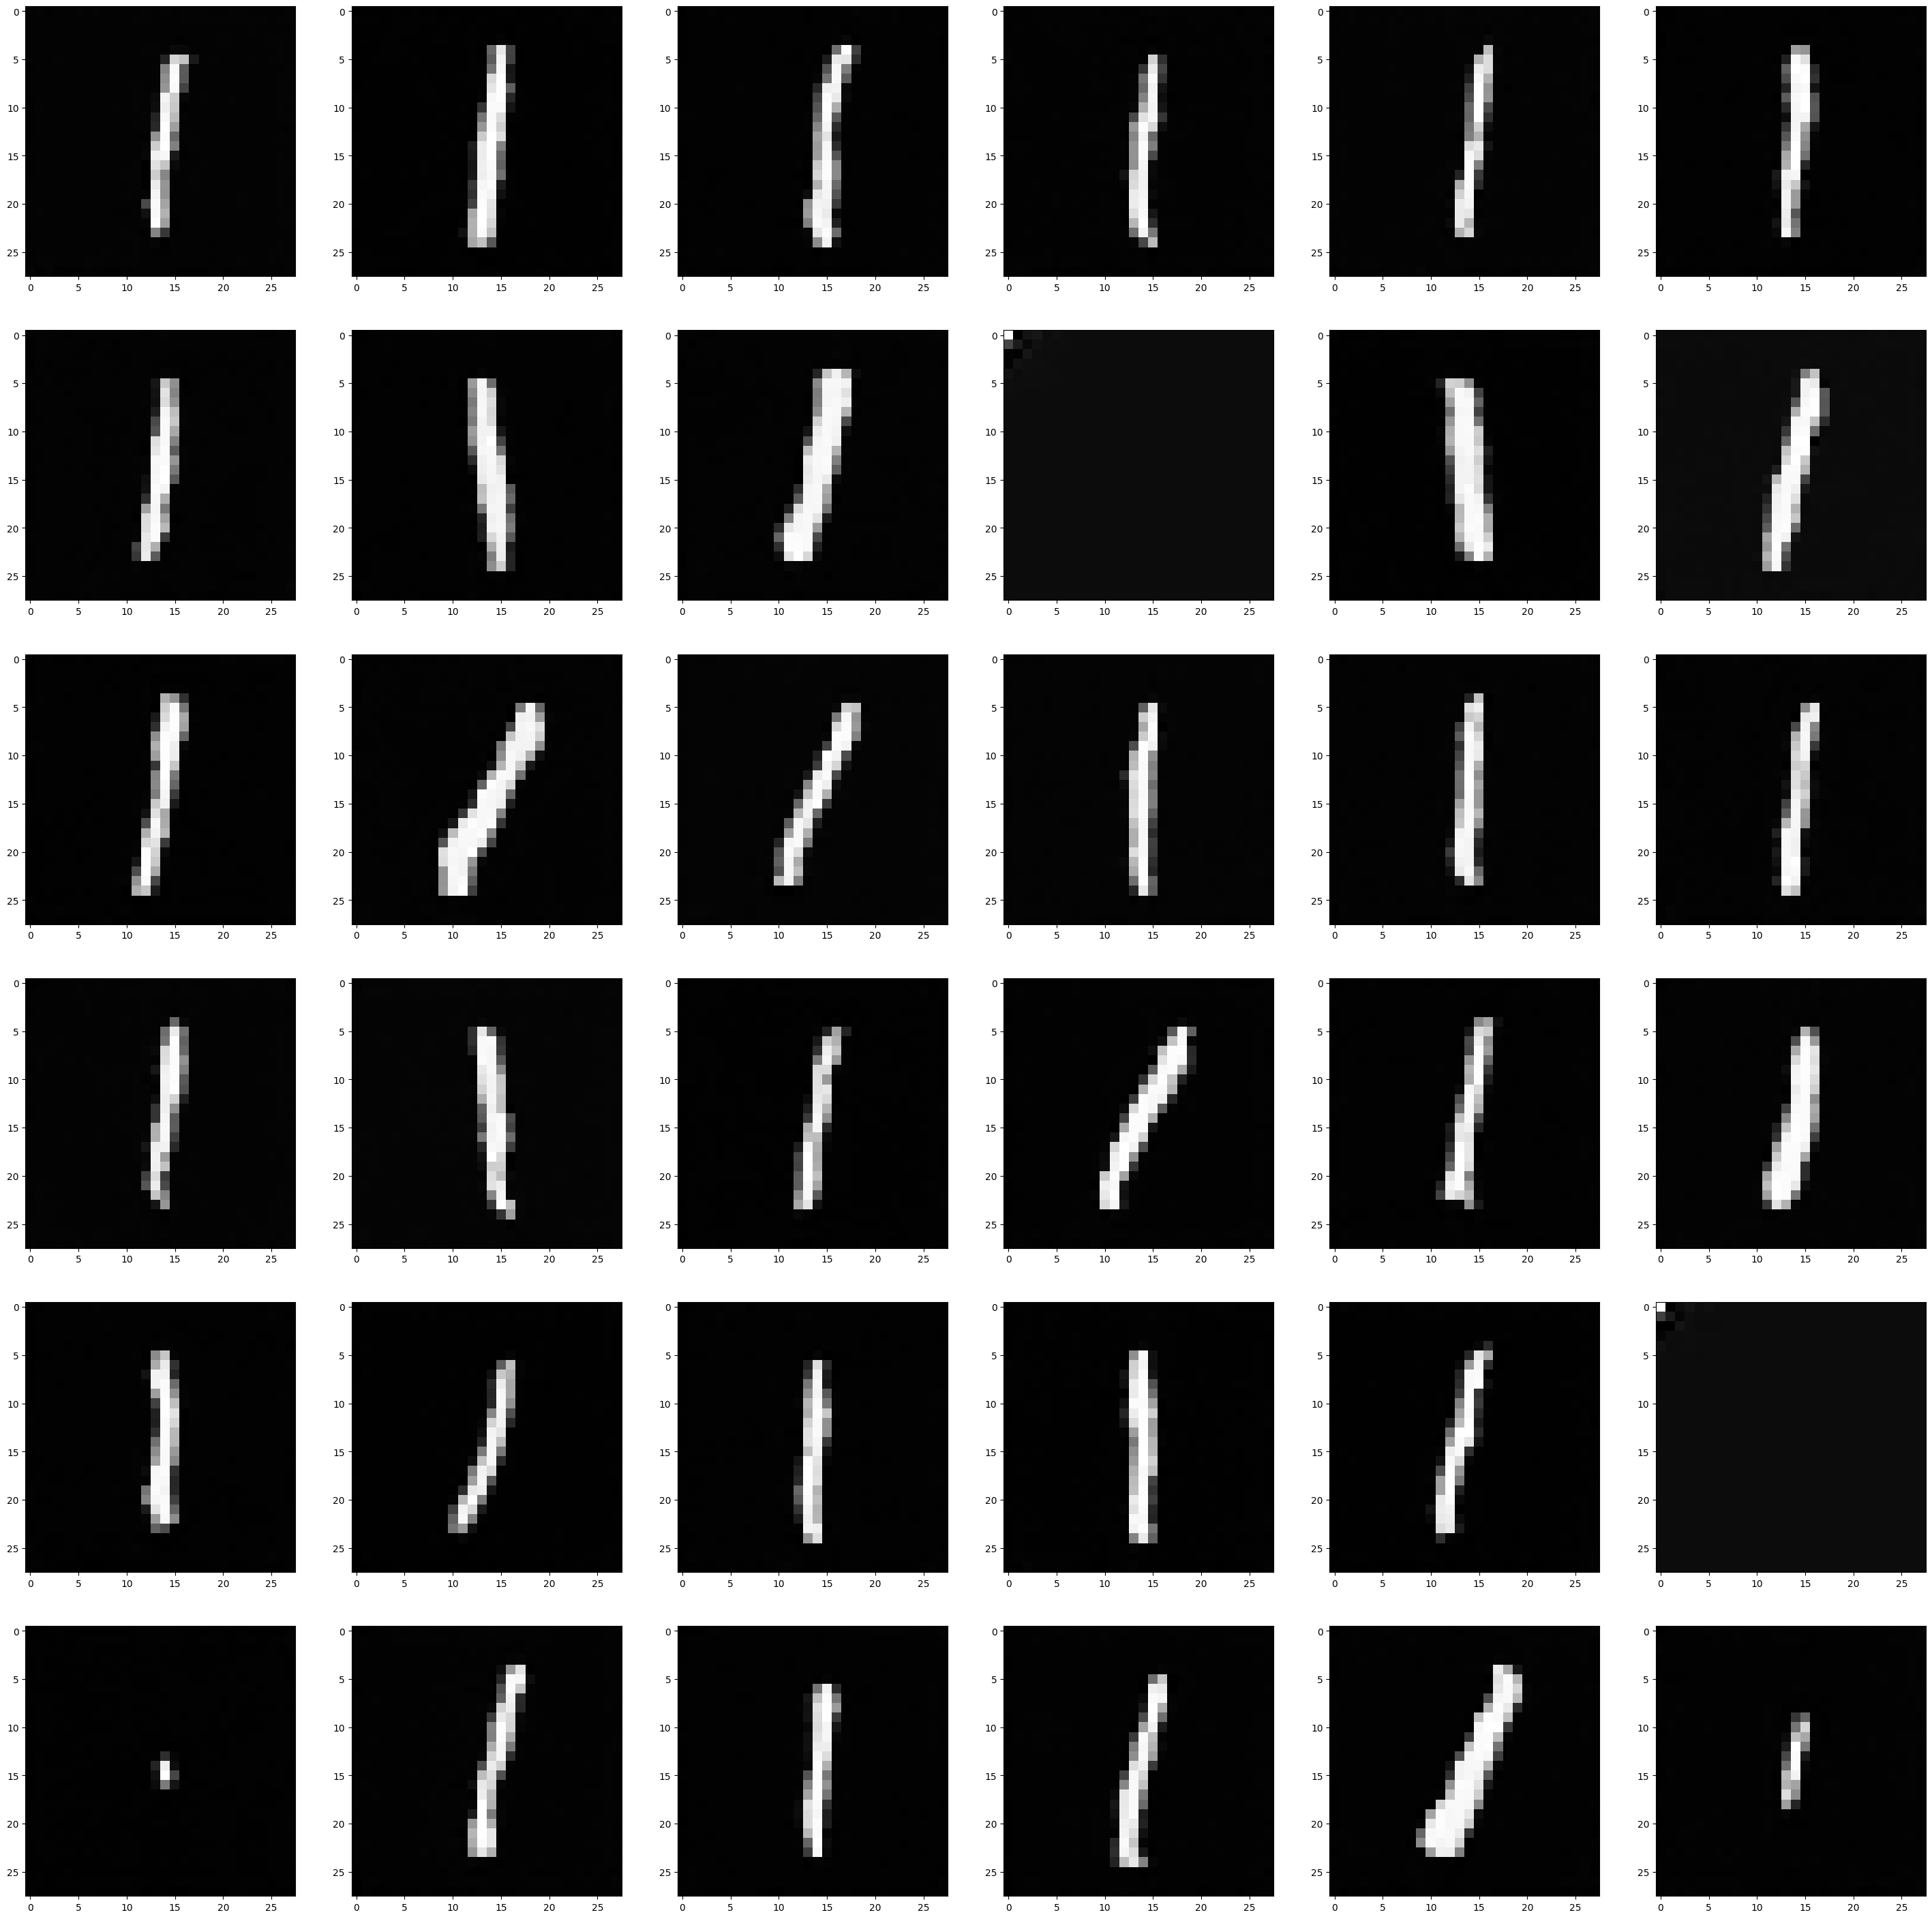

In [ ]:
# Plotting code for your final samples
fig, ax = plt.subplots(ncols=6, nrows=6, figsize=(36,36))
samples_cpu = samples.cpu().detach().numpy()
for i in range(36):
    ax[i//6][i%6].imshow(samples_cpu[0][i][0], cmap='gray',  interpolation='nearest')
plt.savefig("./learned_diffusion_ones.pdf")
plt.show()

## f) Diffusion Visualization
Here you will need to implement a plotting function that visualizes noise turning into a clean sample. Do not forget to label each image with its corresponding denoising step.

In [ ]:
def plot_denoising_process(samples, num_rows=3):
    """
    Plots the denoising process by showing samples at different timesteps.

    Args:
        samples (torch.Tensor): Tensor of shape (1, num_timesteps, 1, 28, 28) containing the samples at different timesteps.
        num_rows (int, optional): Number of rows in the plot grid. Defaults to 3.
    """
    num_timesteps = samples.shape[1]
    num_cols = num_timesteps // num_rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 6 * num_rows))

    for i, ax in enumerate(axes.flat):
        if i < num_timesteps:
            timestep = num_timesteps - i - 1
            ax.imshow(samples[0, timestep, 0], cmap='gray')
            ax.set_title(f'Timestep: {timestep}')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with your samples
plot_denoising_process(samples_cpu)




SyntaxError: invalid syntax (<ipython-input-64-adaed692919d>, line 29)